## Instalar librerias necesarias

Vamo a crear un nuevo ambiente virtual.

'''python

conda create --name goes_r -c conda-forge matplotlib netcdf4 cartopy boto3 gdal scipy pandas Python=x.x.xx

'''


Podemos descargar datos desde el siguiente enlace ()

In [1]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python
from utilities import download_CMI              # Our function for download
gdal.PushErrorHandler('CPLQuietErrorHandler')   # Ignore GDAL warnings

0

In [2]:
# Input and output directories
input = "Samples"; os.makedirs(input, exist_ok=True)
output = "Output"; os.makedirs(output, exist_ok=True)

# Desired extent
extent = [-85.0, -20.0, -65.0, 2.0] # Min lon, Min lat lon, Max lon, Max lat

# AMAZON repository information 
# https://noaa-goes16.s3.amazonaws.com/index.html
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-CMIPF'
yyyymmddhhmn = '202210271800' 
band = '13'

# Download the file
file_name = download_CMI(yyyymmddhhmn, band, input)


In [3]:
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_name}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
ds = (ds * scale + offset) - 273.15

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName('MEM')
raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file  
kwargs = {'format': 'netCDF', \
          'srcSRS': source_prj, \
          'dstSRS': target_prj, \
          'outputBounds': (extent[0], extent[3], extent[2], extent[1]), \
          'outputBoundsSRS': target_prj, \
          'outputType': gdal.GDT_Float32, \
          'srcNodata': undef, \
          'dstNodata': 'nan', \
          'xRes': 0.02, \
          'yRes': 0.02, \
          'resampleAlg': gdal.GRA_NearestNeighbour}

# Write the reprojected file on disk
gdal.Warp(f'{output}/{file_name}_ret.nc', raw, **kwargs)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f7f0c6927b0> >

Text(0.0, 1.0, 'GOES-16 Band 13 2022-10-27 18:00 UTC')

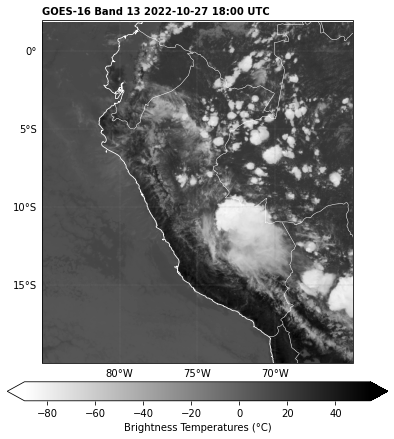

In [4]:
# Open the reprojected GOES-R image
file = Dataset(f'{output}/{file_name}_ret.nc')

# Get the pixel values
data = file.variables['Band1'][:]
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(7,7))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels
    
# Plot the image
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--',
linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), 
draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', 
orientation='horizontal', pad=0.05, fraction=0.05)

# Extract the date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', 
fontweight='bold', fontsize=10, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')